In [12]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# ==== Config ====
DATASET_PATH = "C:/NeuroNurture/Javafest_agor/Games/models_and_datasets/gesture_dataset"
MODEL_PATH = "hand_landmarker.task"  # Your MediaPipe hand landmark model
OUTPUT_FILE = "processed_hand_gesture_dataset.npy"

# ==== STEP 1: Create the HandLandmarker ====
base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# ==== STEP 2: Utility to Extract Landmarks ====
def extract_landmarks_from_image(image_path):
    try:
        mp_image = mp.Image.create_from_file(image_path)
        result = detector.detect(mp_image)
        if not result.hand_landmarks:
            return None

        landmarks = []
        for hand in result.hand_landmarks:
            for lm in hand:
                landmarks.extend([lm.x, lm.y, lm.z])

        # Pad for missing hand (if only 1 detected)
        while len(landmarks) < 126:
            landmarks.extend([0.0, 0.0, 0.0])
        return landmarks
    except:
        return None

# ==== STEP 3: Iterate over Dataset ====
dataset = []

for label in tqdm(os.listdir(DATASET_PATH), desc="Processing labels"):
    label_path = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(label_path):
        continue

    for img_name in tqdm(os.listdir(label_path), desc=f"Processing '{label}'", leave=False):
        img_path = os.path.join(label_path, img_name)

        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        landmarks = extract_landmarks_from_image(img_path)
        if landmarks is not None:
            dataset.append([label, landmarks])

# ==== STEP 4: Save Data ====
np_data = np.array(dataset, dtype=object)
np.save(OUTPUT_FILE, np_data)
print(f"✅ Saved {len(dataset)} samples to '{OUTPUT_FILE}'")


Processing labels: 100%|██████████| 13/13 [01:05<00:00,  5.07s/it]


✅ Saved 1200 samples to 'processed_hand_gesture_dataset.npy'


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Load the data if saved earlier
data = np.load("processed_hand_gesture_dataset.npy", allow_pickle=True)

# Separate features and labels
X = []
y = []

for label, landmarks in data:
    X.append(landmarks)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(np.shape(X))
print(np.shape(y))




(1200, 126)
(1200,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Define classifiers
models = {
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Evaluate each model
print("🔍 Accuracy Results:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:<20} : {acc:.4f}")

🔍 Accuracy Results:

Random Forest        : 0.9167
Logistic Regression  : 0.8792
SVM (RBF Kernel)     : 0.7000
KNN                  : 0.9000
Decision Tree        : 0.8375
Gradient Boosting    : 0.9417


In [16]:
import joblib
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
# Save model
joblib.dump(model, "gesture_model.pkl")
print("✅ Model saved as 'gesture_model.pkl'")


Accuracy: 0.9458
✅ Model saved as 'gesture_model.pkl'


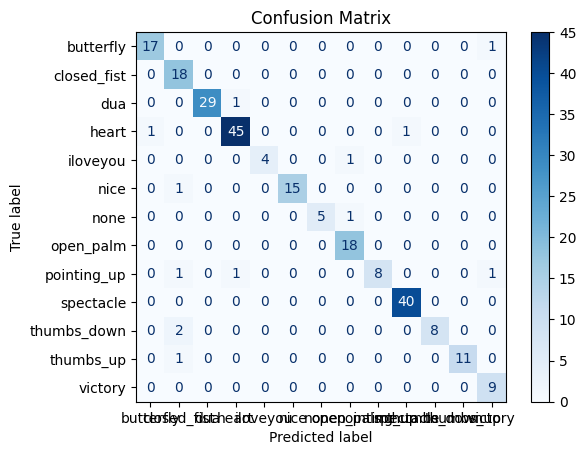

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test: true labels
# y_pred: predicted labels
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
